<a target="_blank" href="https://colab.research.google.com/github/davalpez/MyKaggle/blob/master/Tensorflow%20basics/NLP-Project-Simplify.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# NLP Project : Simplify

This is a project that is part of the Tensorflow Deep Learning bootcamp from Udemy.

**Overview**

The objective of this project is to create a NLP model that transforms convoluted written abstract into an easier readable format.

The data user will be taken from this source:
https://arxiv.org/abs/1710.06071
The model used in this project will be based on:
https://arxiv.org/pdf/1612.05251

**Index guide for the notebook**

1. Notebook setup
2. Fetch dataset
3. Create preprocess functions
4. Draft model experimentation
5. Multimodal model creation
6. Visualize predictions
7. Test model

## Notebook Setup

As we have done before, we will first import our own library file where we store functions introduced in other notebooks to continue more efficiently.

In [2]:
import sys
import os

sys.path.append(os.path.abspath("../lib"))

In [3]:
import importlib
import modelgraph  # Import the module
importlib.reload(modelgraph)  # Reload it after changes

2025-03-03 14:14:31.074656: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741004071.174596     675 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741004071.209036     675 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-03 14:14:31.464368: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


<module 'modelgraph' from '/home/david/VSpython/Git/lib/modelgraph.py'>

In [4]:
!nvidia-smi

Mon Mar  3 14:14:37 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.51                 Driver Version: 561.19         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 2070 ...    On  |   00000000:01:00.0 Off |                  N/A |
| N/A   71C    P3             31W /   80W |     184MiB /   8192MiB |     31%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
import tensorflow as tf
tf.config.set_soft_device_placement(True)
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [6]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


In [7]:
!export TF_GPU_ALLOCATOR=cuda_malloc_async

## Fetch the data

The data we will use is fetched from the this [pubmed-rct repository](https://github.com/Franck-Dernoncourt/pubmed-rct).

!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git ../Sources/pubmed-rct  
!ls ../Sources/pubmed-rct  

Cloning into '../Sources/pubmed-rct'...

PubMed_200k_RCT  
PubMed_200k_RCT_numbers_replaced_with_at_sign  
PubMed_20k_RCT  
PubMed_20k_RCT_numbers_replaced_with_at_sign  
README.md

Checking the content of the file, we have :
* `PubMed 20k` as a lite version of the `PubMed 200k`.
* `PubMed 200k` as the main file containing the abstracts.
*  Copies of `PubMed 200k` and `PubMed 20k` where numbers had been replaced with the `@` symbol.

We will start using the `PubMed 20k replaced with at sign` dataset, as it will be a good representation to train and test our models and figure out what model works best with this type of data. As we progress with our experiments, we can later scale to the `PubMed 200k replaced with at sign`.

In [8]:

# Check what files are in the PubMed_20K dataset 
!ls ../Sources/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


We can see how we already have the dataset separated into train and test files. We also have dev file, which is another way of naming the validation file.

In [9]:
def ReadLinesFromFile(file_path):
    """
    Reads lines from a file and returns them as a list.

    Args:
    file_path (str): The path to the file to be read.

    Returns:
    list: A list of strings, each representing a line from the file.
    """
    with open(file_path, 'r') as file:
        lines = file.readlines()
    return lines

In [10]:

train_path = '../Sources/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt'
train_raw_data_20k = ReadLinesFromFile(train_path)
train_raw_data_20k[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

Let's also take a look to the test and validation data

In [11]:

test_path = '../Sources/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt'
test_raw_data_20k = ReadLinesFromFile(test_path)
test_raw_data_20k[:20]

['###24845963\n',
 'BACKGROUND\tThis study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( ADHF ) .\n',
 'RESULTS\tA post hoc analysis was conducted with the use of data from the Evaluation Study of Congestive Heart Failure and Pulmonary Artery Catheterization Effectiveness ( ESCAPE ) .\n',
 'RESULTS\tLiver function tests ( LFTs ) were measured at @ time points from baseline , at discharge , and up to @ months follow-up .\n',
 'RESULTS\tSurvival analyses were used to assess the association between admission Model of End-Stage Liver Disease Excluding International Normalized Ratio ( MELD-XI ) scores and patient outcome.There was a high prevalence of abnormal baseline ( admission ) LFTs ( albumin @ % , aspartate transaminase @ % , alanine transaminase @ % , and total bilirubin @ % ) .\n',
 "RESULTS\tThe percentage of patients with abnormal LFTs decreased significantly from baseline to @-months ' follow-up .\n",
 'RE

In [12]:
val_path = '../Sources/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt'
val_raw_data_20k = ReadLinesFromFile(val_path)
val_raw_data_20k[:10]

['###24290286\n',
 'BACKGROUND\tIgE sensitization to Aspergillus fumigatus and a positive sputum fungal culture result are common in patients with refractory asthma .\n',
 'BACKGROUND\tIt is not clear whether these patients would benefit from antifungal treatment .\n',
 'OBJECTIVE\tWe sought to determine whether a @-month course of voriconazole improved asthma-related outcomes in patients with asthma who are IgE sensitized to A fumigatus .\n',
 'METHODS\tAsthmatic patients who were IgE sensitized to A fumigatus with a history of at least @ severe exacerbations in the previous @ months were treated for @ months with @ mg of voriconazole twice daily , followed by observation for @ months , in a double-blind , placebo-controlled , randomized design .\n',
 'METHODS\tPrimary outcomes were improvement in quality of life at the end of the treatment period and a reduction in the number of severe exacerbations over the @ months of the study .\n',
 'RESULTS\tSixty-five patients were randomized .

The way the data is structured in this file is :

* A hashtag line indicating a new abstract `###`
* A `ID number` for an specific abstract.
* A `type` for the content of every line.
* A `text`that indentifies with the content of every line.
* An `ES`after every line.

How it would be interesting to format this data into a dictionary per abstract.

1. Line number we are refering from an specific abstract.
2. Specify the type of text.
3. Displaying the text content
4. Total lines.
5. Abstract ID, so we can see and compare the results better after.

In [13]:
def GenerateAbstractSamples(raw_data):
    """
    Generates a prcoessed sampled dataset from a raw dataset. The function takes in a variable
    raw dataset and returns a list of dictionaries, where each dictionary represents an abstract
    sample.

    Args:
    dataset (list): A list of strings, each representing a line from the dataset file.

    Returns:
    list: A list of abstracts, where each abstract is represented as a list of dictionaries. 
          Each dictionary contains the following keys:
          - 'type': The type of the line (e.g., BACKGROUND, METHODS, RESULTS, CONCLUSIONS).
          - 'text': The text content of the line.
          - 'line_number': The line number within the abstract.
          - 'total_lines': The total number of lines in the abstract.
          - 'abstract_id': The ID of the abstract.
    """
    abstracts = []
    current_abstract = None
    line_count = 0
    abstract_id = None

    for line in raw_data:
        if line.startswith('###'):
            if current_abstract:
                for entry in current_abstract:
                    entry['total_lines'] = line_count
                    entry['abstract_id'] = abstract_id
                abstracts.append(current_abstract)
            current_abstract = []
            line_count = 0
            abstract_id = line.strip()[3:]  # Extract the abstract ID
        elif line.strip():
            line_count += 1
            parts = line.split('\t')
            if len(parts) == 2:
                type_, text = parts
                current_abstract.append({
                    'type': type_,
                    'text': text.strip(),
                    'line_number': line_count,
                    'total_lines': 0,  # This will be updated later
                    'abstract_id': abstract_id  # This will be updated later
                })

    if current_abstract:
        for entry in current_abstract:
            entry['total_lines'] = line_count
            entry['abstract_id'] = abstract_id
        abstracts.append(current_abstract)

    return abstracts

# Generate abstracts from the test dataset
train_samples_20k = GenerateAbstractSamples(train_raw_data_20k)
train_samples_20k[:2]  # Print the first 2 abstracts for verification

[[{'type': 'OBJECTIVE',
   'text': 'To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
   'line_number': 1,
   'total_lines': 12,
   'abstract_id': '24293578'},
  {'type': 'METHODS',
   'text': 'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
   'line_number': 2,
   'total_lines': 12,
   'abstract_id': '24293578'},
  {'type': 'METHODS',
   'text': 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
   'line_number': 3,
   'total_lines': 12,
   'abstract_id': '24293578'},
  {'type': 'METHODS',
   'text': 'Pain was assessed using the visual analog pain scale ( @-@ mm ) .',
   'line_number': 4,
   'total_lin

It is looking good now as we have the data now properly organizded and in a format that is easier to extract. We can also transform it into a pandas dataframe for better visualization.

In [14]:
test_samples_20k = GenerateAbstractSamples(test_raw_data_20k)
val_samples_20k = GenerateAbstractSamples(val_raw_data_20k)

In [15]:
len(train_samples_20k), len(val_samples_20k), len(test_samples_20k)

(15000, 2500, 2500)

In [16]:
import pandas as pd

def CreateSampleDf(Samples):
    # Create a dataframe for each sample in Samples
    sample_dfs = [pd.DataFrame(sample) for sample in Samples]

    # Combine all the dataframes into a single dataframe
    combined_df = pd.concat(sample_dfs, ignore_index=True)
    return combined_df

In [17]:
train_df_20k = CreateSampleDf(train_samples_20k)
val_df_20k = CreateSampleDf(val_samples_20k)
test_df_20k = CreateSampleDf(test_samples_20k)

In [18]:
train_df_20k.head(16)

,type,text,line_number,total_lines,abstract_id
0,OBJECTIVE,To investigate the efficacy of @ weeks of dail...,1,12,24293578
1,METHODS,A total of @ patients with primary knee OA wer...,2,12,24293578
2,METHODS,Outcome measures included pain reduction and i...,3,12,24293578
3,METHODS,Pain was assessed using the visual analog pain...,4,12,24293578
4,METHODS,Secondary outcome measures included the Wester...,5,12,24293578
5,METHODS,"Serum levels of interleukin @ ( IL-@ ) , IL-@ ...",6,12,24293578
6,RESULTS,There was a clinically relevant reduction in t...,7,12,24293578
7,RESULTS,The mean difference between treatment arms ( @...,8,12,24293578
8,RESULTS,"Further , there was a clinically relevant redu...",9,12,24293578
9,RESULTS,These differences remained significant at @ we...,10,12,24293578


We can see now in this dataframe we have all the abstracts together and we can see the separation by seeing the change in the `abstract_id` or `total_lines` changing. We could create a dataframe where we have each sample saved as well, but we have decided to go this way for now to visualize some metrics better as we are showing in the following cells:

In [19]:

# Distribution of labels in training data
train_df_20k.type.value_counts()

type
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

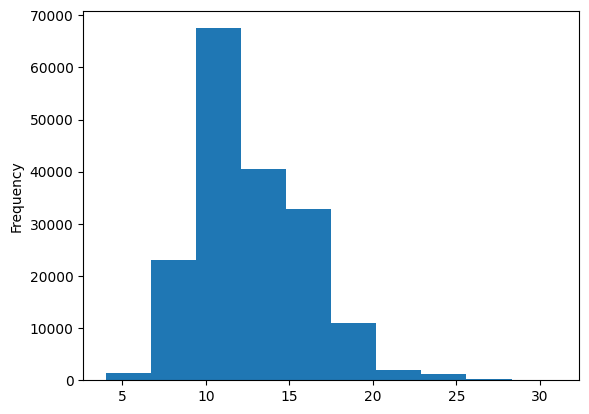

In [20]:
train_df_20k.total_lines.plot.hist()

In [21]:
train_df_20k.total_lines.mean()

np.float64(12.789135747611642)

We can see that most of the content on each asbtract is shared between `methods` and `results` and that the average of total lines is 12.78, while most of them are allocated between 7 and 15 in a normal distribution.

## Create preprocess functions

Now, we need to turn this data into a data that our model can process and understand. For this purpose, we will use one hot encoding and encoded labels.

In [22]:

# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df_20k["type"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df_20k["type"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df_20k["type"].to_numpy().reshape(-1, 1))

# Check what training labels look like
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

Now we transform the one-hot to label encoded. 

In [23]:
from sklearn.preprocessing import LabelEncoder

# Encode labels for train, validation, and test datasets

label_encoder = LabelEncoder()

# Encode labels for training data
train_labels_encoded = label_encoder.fit_transform(train_df_20k["type"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df_20k["type"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df_20k["type"].to_numpy())

# Check the encoded labels
train_labels_encoded[:10]

array([3, 2, 2, 2, 2, 2, 4, 4, 4, 4])

And we can have the direct assigment to the classes.

In [24]:

# Get class names and number of classes from LabelEncoder instance 
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names
     

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

We will also save the text to a string list as this is what we will fit into our model.

In [25]:
# Convert abstract text lines into lists 
train_sentences = train_df_20k["text"].tolist()
val_sentences = val_df_20k["text"].tolist()
test_sentences = test_df_20k["text"].tolist()

For creating an embedding layer later on for dense models, we need to still prepare some part of the data. We checked what is the average number of sentences for minding what lenght we want to use in our model and if we want to use padding. But we also need to analyze the amount of words we have per sentence.

In [26]:
import numpy as np
train_sentence_lengths = [len(sentence.split()) for sentence in train_sentences]
avg_train_sentence_length = np.mean(train_sentence_lengths)
avg_train_sentence_length

np.float64(26.338269273494777)

Taking a view of how the data is distributed

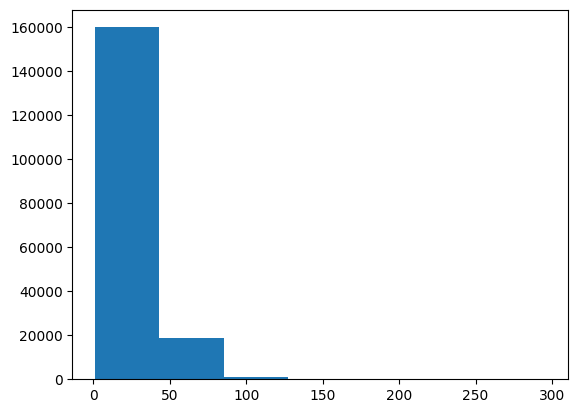

In [27]:
import matplotlib.pyplot as plt
plt.hist(train_sentence_lengths, bins=7);

If we want to see how many tokens would need the 95% of our sentences...

In [28]:

# How long of a sentence covers 95% of the lengths?
output_seq_len = int(np.percentile(train_sentence_lengths, 95))
output_seq_len
     

55

And just to have an idea of what are some outliers here:

In [29]:
max(train_sentence_lengths),min(train_sentence_lengths)

(296, 1)

## Draft Model Experimentation

We are ready to start doing our experiments as our data has been preprocessed. We will draft a plan as we have done before to know where will we start and how we will try to experiment and improve through different models.

 **Model iteration**      | **Model description**                                                                 |
|--------------------------|---------------------------------------------------------------------------------|
| **model_0**          | Model based on Naive Bayes, it will be our baseline |
| **model_1**      | Convolutional Neural Network  that will use Conv1D. Will use word-token embedding. |
| **model_2**      | **model_1**, but we will add an extra LSTM layer.|
| **model_3**      | Transfer learning based Model, using Universal Sentence Encoder. |
| **model_4**      | CNN similar to **model_1**, but we will use character embedding.  |
| **model_5**      | CNN that wil use word and character combined embedding (with U-encoder).  |
| **model_6**      | **model_5** that will use also positional embedding (with U-encoder). |

## Model 0 : Baseline model based on Naive Bayes

Our baseline model will be a the TF-IDF Multinomial Naive Bayes model. As we did in our previous TF-NLP.ipynb, this is a simple model but that can be quite effective for simple task. Let's see how it performs here.

In [30]:

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
  ("tf-idf", TfidfVectorizer()),
  ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences, 
            y=train_labels_encoded);

We can already see how our model will classify the sentences from the validation set.

In [31]:
# Evaluate baseline on validation dataset
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

For a baseline model, it is quite a good results to achieve 72.18% accuracy. 7 out of 10 sentences will be categorized correctly from any abstract we read, and we can improve this results with more complex models in the future.

To keep track of our progress, we can calculate the scores of this model and each model in the future and do comparisons to see what model will perform best for this task.

In [32]:
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [33]:
baseline_results = modelgraph.calculate_results(y_true=val_labels_encoded, 
                                    y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Model 1: Conv1d

In order to build our first CNN for working on this NLP model, we need to start creating the first layers that will proccess our inputs (the text sentences) converting them into tokens and and add a group value for each sentence through our embedding layer.

### Creating text vectorizarion for the dense models 

From the [PubMed200k RCT paper](https://arxiv.org/pdf/1710.06071), we can see that the PubMed20K raw data has 68.000 words and the 200k has 311.000 words. So for this model we can declare that maximum amount of tokens will be 68k for our [text vectorizer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization).

As we checked before, the average sentence lenght is 26 but we will go for a 55 expected sentence lenght as the 95% of our data will have that lenght( and we don't want to lose valuable information from the abstracts).

In [34]:
from tensorflow.keras.layers import TextVectorization

max_tokens = 68000
expected_sentence_lenght = 55

text_vectorizer = TextVectorization(max_tokens=max_tokens, # number of words in vocabulary
                                    output_sequence_length=expected_sentence_lenght) # desired output length of vectorized sequences
     

I0000 00:00:1741004097.581742     675 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6096 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5


Now that we have created our text_vectorizer, we need to pass it our text data so we have values assigned to our tokens.

In [35]:

# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

We can take a look to an example and see how some sentence now has been converted to an specific token.

In [36]:

# Test out text vectorizer
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text:\n{text_vectorizer([target_sentence])}")

Text:
In both groups normal saline was applied to the other nostril on the same material with the MMC side .

Length of text: 20

Vectorized text:
[[    5    54    24   417   622    10   551     6     2   168 10643    18
      2   431  1904     7     2  5986   493     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


We can see this sentence has the expected average lenght. As we still need to be wary of longer sentences, we have the expectetation of 55 words(tokens), so we count with padding to fill the unused spaces.

Let's check from our text vectorizer what are the most and least commont words.

In [37]:
rct_20k_vocab = text_vectorizer.get_vocabulary()
rct_20k_vocab = [str(word) for word in rct_20k_vocab]
print(f"Words in vocabulary: {len(rct_20k_vocab)}")
print(f"Most common words : {rct_20k_vocab[:5]}")
print(f"Least common words : {rct_20k_vocab[-5:]}")

Words in vocabulary: 64841
Most common words : ['', '[UNK]', 'the', 'and', 'of']
Least common words : ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [38]:
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': {'module': 'keras',
  'class_name': 'DTypePolicy',
  'config': {'name': 'float32'},
  'registered_name': None},
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

### Create the embedding layer for this specific model

Now that we created our text vectorizer, we need to create the [embedding layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) so we can provide some relations between the numbers we are feeding into our model.

As our model learns, the embedding layer will be updated and so, the relation concept that our embedding layer has between the tokens will evolve in time.

In [39]:
from tensorflow.keras.layers import Embedding
# Create token embedding layer
embedding_layer_0 = Embedding(input_dim=len(rct_20k_vocab), # length of vocabulary
                               output_dim=128, # Note: different embedding sizes result in drastically different numbers of parameters to train
                               # Use masking to handle variable sequence lengths (save space)
                               mask_zero=True,
                               name="embedding_layer_0") 

If we want to see an example : 

In [40]:
# Show example embedding
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = embedding_layer_0(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
In both groups normal saline was applied to the other nostril on the same material with the MMC side .

Sentence after vectorization (before embedding):
[[    5    54    24   417   622    10   551     6     2   168 10643    18
      2   431  1904     7     2  5986   493     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
[[[ 0.03388942  0.03603176 -0.01028138 ...  0.04974503  0.0377668
   -0.00559308]
  [ 0.04090755  0.04433343 -0.03185729 ...  0.00298112  0.02188045
   -0.0236961 ]
  [ 0.00434185 -0.03179999 -0.02732526 ...  0.00174892 -0.03609366
   -0.04260771]
  ...
  [ 0.02355808  0.04051416  0.04110893 ... -0.03749721 -0.02273949
   -0.04647721]
  [ 0.02355808  0.04051416  0.04110893 ... -0.03749721 -0.02273949
   -0.04647721]
  [ 0.02355808  0.04051416 

### Creating the dataset for our dense model

We have created our dataframes before with pandas and have organized our data. We can still make it easier for our model to process this data with the [tf.data API](https://www.tensorflow.org/guide/data). 

Choosing this method to prepare our data will take advantage of GPU usage and prepare the input pipeline [faster](https://www.tensorflow.org/guide/data_performance).

In [41]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [42]:
# Take the TensorSliceDataset's and turn them into prefetched batches
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

### Creating and training the model

Now that we have our input processing layers created, our model is ready to be built.

The structure we want to follow for the model is:
 1. **Input** layer that will receive text.
 2. **Tokenization** of the text.
 3. **Embedding** process to stablish numerical relations.
 4. **Grouped convoluted layers** to process and classify the relations.
 5. **Ouput probability** for each sentence, determining the class of each sentence.

So let's start creating now our Convoluted 1 Dimension model.

In [43]:
# Set random seed for weight initialization.
tf.random.set_seed(10)

# 1. Create the model.

from tensorflow.keras.layers import Input,Conv1D,GlobalAveragePooling1D,Dense,LSTM
from tensorflow.keras import Model

# Create 1D convolutional model to process sequences
inputs = Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = embedding_layer_0(text_vectors) # create embedding
#x = LSTM(32, return_sequences=True)(token_embeddings) # condense the output of our feature vector
x = Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = GlobalAveragePooling1D()(x) # condense the output of our feature vector
outputs = Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

/home/david/VSpython/venv311/lib/python3.11/site-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [44]:
model_1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization              │ (None, 55)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_layer_0 (Embedding)   │ (None, 55, 128)        │     8,299,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 55, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,340,997 (31.82 MB)

 Trainable params: 8,340,997 (31.82 MB)

 Non-trainable params: 0 (0.00 B)

We have quite a big amount of training parameters for our embedding layer if we take a look at the summary of our first convolution model.

As we have also a large dataset (15k training samples, 2.5k of test and 2.5k of validation samples), so just to have an idea of how good the model could perform, we can use a 10% of the dataset to see how good the performance can be, we will take just a sub-set from it.

It is a good practice to test the model on a small dataset and scale up as we progress in our experiments. 10% of the data is good, as long as we cover a good distribution of our data.

In [45]:
# 2. Compile the model
model_1.compile(loss="categorical_crossentropy", # if your labels are integer form (not one hot) use sparse_categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [46]:
# 3. Fit the model
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)), # only fit on 10% of batches for faster training time
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset))) # only validate on 10% of batches
     

Epoch 1/3


I0000 00:00:1741004108.413493    1076 cuda_dnn.cc:529] Loaded cuDNN version 90300


562/562 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.5200 - loss: 1.1725 - val_accuracy: 0.7390 - val_loss: 0.6891
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.7422 - loss: 0.6876 - val_accuracy: 0.7666 - val_loss: 0.6408
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - accuracy: 0.7716 - loss: 0.6273 - val_accuracy: 0.7826 - val_loss: 0.6000


### Evaluating Model 1

Training the model didn't take too long in the end and we have achieved a good accuracy. Let's make some predictions and see what score we achieve with this model.

In [47]:
# Evaluate on whole validation dataset (we only validated on 10% of batches during training)
model_1.evaluate(valid_dataset)

  1/945 ━━━━━━━━━━━━━━━━━━━━ 18s 20ms/step - accuracy: 0.5000 - loss: 0.8556

945/945 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - accuracy: 0.7848 - loss: 0.5981


[0.6011026501655579, 0.7843241095542908]

In [48]:
# Make predictions (our model outputs prediction probabilities for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs

945/945 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step


array([[4.0455067e-01, 1.7965423e-01, 1.1555918e-01, 2.6498926e-01,
        3.5246663e-02],
       [4.2003778e-01, 3.0842087e-01, 9.4588911e-03, 2.5367475e-01,
        8.4077856e-03],
       [1.2461042e-01, 5.7232915e-03, 2.3639004e-03, 8.6726344e-01,
        3.8967493e-05],
       ...,
       [8.3482082e-06, 8.8984059e-04, 9.4145886e-04, 4.3868836e-06,
        9.9815601e-01],
       [4.7465149e-02, 4.4867158e-01, 8.4411159e-02, 4.6190836e-02,
        3.7326124e-01],
       [2.3289369e-01, 5.9442633e-01, 5.9695464e-02, 4.1230779e-02,
        7.1753733e-02]], dtype=float32)

In [49]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [50]:

# Calculate model_1 results
model_1_results = modelgraph.calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.43241096253143,
 'precision': 0.7808856563623187,
 'recall': 0.7843241096253144,
 'f1': 0.7821279789309675}

In [51]:
modelgraph.CompareModelScores(baseline_results, model_1_results)

Baseline accuracy: 72.18, New accuracy: 78.43, Difference: 6.25
Baseline precision: 0.72, New precision: 0.78, Difference: 0.06
Baseline recall: 0.72, New recall: 0.78, Difference: 0.06
Baseline f1: 0.70, New f1: 0.78, Difference: 0.08


Let's jump into the next model now

## Model 2 : Model 1, adding a LSTM layer

This model doesn't need much explanation. We will use a LSTM layer as it is recommended to save some information from the embedding layer before passing it into the convolutional 1D layer.

In [52]:
# Create token embedding layer
embedding_layer_1 = Embedding(input_dim=len(rct_20k_vocab), # length of vocabulary
                               output_dim=128, # Note: different embedding sizes result in drastically different numbers of parameters to train
                               # Use masking to handle variable sequence lengths (save space)
                               mask_zero=False,
                               name="embedding_layer_1") 


In [53]:
# Set random seed for weight initialization.
tf.random.set_seed(10)

# 1. Create the model.
from tensorflow.keras.layers import Bidirectional

# Create 1D convolutional model to process sequences
inputs = Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = embedding_layer_1(text_vectors) # create embedding
x = Bidirectional(LSTM(32, return_sequences=True))(token_embeddings)  # CuDNN-enabledx = Conv1D(64, kernel_size=5, padding="same", activation="relu")(x)
x = GlobalAveragePooling1D()(x) # condense the output of our feature vector
outputs = Dense(num_classes, activation="softmax")(x)
model_2 = tf.keras.Model(inputs, outputs)

In [54]:
model_2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization              │ (None, 55)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_layer_1 (Embedding)   │ (None, 55, 128)        │     8,299,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 55, 64)         │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,341,189 (31.82 MB)

 Trainable params: 8,341,189 (31.82 MB)

 Non-trainable params: 0 (0.00 B)

In [55]:
# 2. Compile the model
model_2.compile(loss="categorical_crossentropy", # if your labels are integer form (not one hot) use sparse_categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# 3. Fit the model
model_2_history = model_2.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)), # only fit on 10% of batches for faster training time
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset))) # only validate on 10% of batches

Epoch 1/3


562/562 ━━━━━━━━━━━━━━━━━━━━ 42s 56ms/step - accuracy: 0.4976 - loss: 1.2004 - val_accuracy: 0.6902 - val_loss: 0.7426
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 31s 55ms/step - accuracy: 0.7108 - loss: 0.7339 - val_accuracy: 0.7380 - val_loss: 0.6823
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 36s 64ms/step - accuracy: 0.7421 - loss: 0.6580 - val_accuracy: 0.7680 - val_loss: 0.5916


### Evaluating model 2

In [56]:
# Make predictions (our model outputs prediction probabilities for each class)
model_2_pred_probs = model_2.predict(valid_dataset)

# Convert pred probs to classes
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds


# Calculate model_2
model_2_results = modelgraph.calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

945/945 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step


{'accuracy': 76.88666754931816,
 'precision': 0.7673281546579521,
 'recall': 0.7688666754931816,
 'f1': 0.7654153188806485}

In [57]:
modelgraph.CompareModelScores(model_1_results,model_2_results)

Baseline accuracy: 78.43, New accuracy: 76.89, Difference: -1.55
Baseline precision: 0.78, New precision: 0.77, Difference: -0.01
Baseline recall: 0.78, New recall: 0.77, Difference: -0.02
Baseline f1: 0.78, New f1: 0.77, Difference: -0.02


Seems adding a Bidirectional LSTM did not have a great impact.

## Model 3 : Transfer Learning based Model

For this model, we are going to use a model that replicates the architecture used in [Neural Netowrks for Joint Sentence classification](https://arxiv.org/pdf/1612.05251), which is the [GloVe](https://nlp.stanford.edu/projects/glove/) (Global Vectors for Word Representation)

For our experiment, we can try to use transfer-learning model as a way of emulating this paper's approach. 

We will instead use a pretrain embedding (Universal Sentence Encoder) and then build our model on top of that.

In [58]:
import tensorflow_hub as hub

print("TF Version: " + tf.__version__)
print("TF Hub version " + hub.__version__)

TF Version: 2.18.0
TF Hub version 0.16.1


In [59]:
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [60]:
import random

# Test out the embedding on a random sentence
random_training_sentence = random.choice(train_sentences)
print(f"Random training sentence:\n{random_training_sentence}\n")
use_embedded_sentence = tf_hub_embedding_layer([random_training_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]} (truncated output)...\n")
print(f"Length of sentence embedding:\n{len(use_embedded_sentence[0])}")

Random training sentence:
A randomized , repeated-measures study of Onefit P&A , msd , and Jupiter was performed .

Sentence after embedding:
[ 0.01949052  0.06197231 -0.02024122 -0.06413496  0.0308162  -0.03106964
  0.06929907  0.01055952  0.07666997  0.00643357 -0.0179629   0.01942274
  0.05109183  0.06796951 -0.01064912 -0.03446417  0.02260244  0.04055231
  0.06427071 -0.06859721  0.0132888   0.03488066 -0.05504282  0.05381745
  0.01277634 -0.03742447  0.06901779  0.01739612 -0.01675461  0.02468678] (truncated output)...

Length of sentence embedding:
512


The only issue we have when using Tensorflow_hub is that we need to ensure that the `hub.KerasLayer` is properly used within the Keras model. The error occurs because the `hub.KerasLayer` expects a TensorFlow tensor, not a Keras tensor. That is why in this case we wrap  the `hub.KerasLayer` in a custom Keras layer.

The downside of following this procedure is that we can't see the full trainable parameters we are having this layer.

This is due to having Tensorflow 2.18 installed that deals with Keras 3 models. This provokes some incompatiblities between keras and tensorflow. The problem of rolling back to 2.15 where these issues don't exist relay on the rest of the function from tensorflow that have been updated to improve better overall efficiency from this library.

In [61]:
import tf_keras as keras

version_fn = getattr(tf.keras, 'version', None)
print('TF Version: ' + tf.__version__)
print('TF keras version ' + keras.__version__)
print('TF Keras Version: ' + version_fn())
print('TF Hub version ' + hub.__version__)
print('Python Version: ' + sys.version)

TF Version: 2.18.0
TF keras version 2.18.0
TF Keras Version: 3.8.0
TF Hub version 0.16.1
Python Version: 3.11.11 (main, Dec  4 2024, 08:55:08) [GCC 13.2.0]


In [62]:
import tensorflow_hub as hub
import tensorflow as tf
from tf_keras import layers
import tf_keras as keras

# Set random seed for weight initialization.
keras.utils.set_random_seed(10)

# 1.Create the model
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embeddings = tf_hub_embedding_layer(inputs)
x = layers.Dense(128, activation="relu")(pretrained_embeddings)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model_3 = keras.Model(inputs, outputs,name="model_3")



In [63]:
# 2.Compile the model
model_3.compile(loss="categorical_crossentropy",
                optimizer=keras.optimizers.Adam(),
                metrics=["accuracy"])

In [64]:
model_3.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder  (None, 512)               256797824 
  (KerasLayer)                                                   
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dense_1 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256864133 (979.86 MB)
Trainable params: 66309 (259.02 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


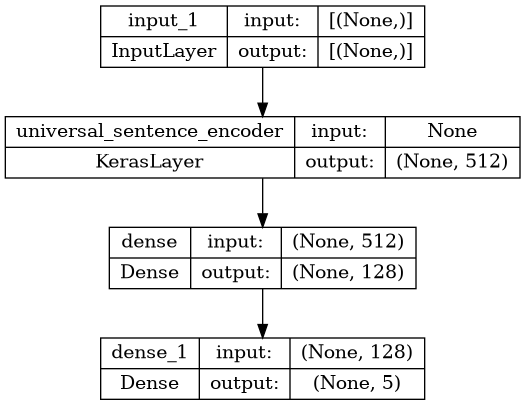

In [65]:
from tf_keras.utils import plot_model
plot_model(model_3, show_shapes=True, show_layer_names=True)

In [66]:
model_3_history = model_3.fit(t,
                              steps_per_epoch=int(0.1 * len(train_dataset)), # only fit on 10% of batches for faster training time
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset))) # only validate on 10% of batches

Epoch 1/3


I0000 00:00:1741004506.260478    1076 service.cc:148] XLA service 0x7fcdc4053740 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1741004506.260813    1076 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 2070 with Max-Q Design, Compute Capability 7.5
2025-03-03 14:21:46.278891: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1741004506.459391    1076 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


562/562 [==============================] - 42s 54ms/step - loss: 0.9168 - accuracy: 0.6521 - val_loss: 0.8005 - val_accuracy: 0.6908
Epoch 2/3
562/562 [==============================] - 28s 50ms/step - loss: 0.7716 - accuracy: 0.7013 - val_loss: 0.7590 - val_accuracy: 0.7008
Epoch 3/3
562/562 [==============================] - 32s 57ms/step - loss: 0.7556 - accuracy: 0.7112 - val_loss: 0.7419 - val_accuracy: 0.7148


### Evaluating model 3

As we have done before, lets evaluate and compare scores


In [67]:
# Make predictions (our model outputs prediction probabilities for each class)
model_3_pred_probs = model_3.predict(valid_dataset)

# Convert pred probs to classes
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds


# Calculate model_2
model_3_results = modelgraph.calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_3_preds)
model_3_results

945/945 [==============================] - 38s 39ms/step


{'accuracy': 71.2895538196743,
 'precision': 0.7134472838268037,
 'recall': 0.712895538196743,
 'f1': 0.7099143550925746}

Comparing with the best model so far (model 1)

In [68]:
modelgraph.CompareModelScores(model_1_results, model_3_results)

Baseline accuracy: 78.43, New accuracy: 71.29, Difference: -7.14
Baseline precision: 0.78, New precision: 0.71, Difference: -0.07
Baseline recall: 0.78, New recall: 0.71, Difference: -0.07
Baseline f1: 0.78, New f1: 0.71, Difference: -0.07


Our transfer learning model has a worse accuracy on the validation dataset. What could be the reasons for it?
Well, the principal issue could be that the training dataset vocabulary could be a bit different than the one that the universal encoder was trained on. Our model was very specifically trained on this type of vocabulary, so there is the chance that our model is doing greater.

Still, transfer-learning model can achieve an outstanding performance, but it needs some tweeks and train-scaling for it.

## Model 4: Conv1d with character embeddings


When reading about the architecture used in [Neural Netowrks for Joint Sentence classification](https://arxiv.org/pdf/1612.05251), it is mentioned that the model uses a hybrid of token and character embedding.

Our previous model use custom token embedding and pretrained token embedding, so we could try using character embedding.

By using the `TextVectorizer` we can create a character-evel embedding, and then we can pass these results to an `embedding layer`.

First, we need to split the sentences into characters.

### Creating character vectorizer

In [69]:
# Make function to split sentences into characters
def SplitIntoChars(text):
  return " ".join(list(text))

In [70]:
# Test splitting non-character-level sequence into characters
SplitIntoChars(random_training_sentence)

'A   r a n d o m i z e d   ,   r e p e a t e d - m e a s u r e s   s t u d y   o f   O n e f i t   P & A   ,   m s d   ,   a n d   J u p i t e r   w a s   p e r f o r m e d   .'

Creating then a new dataset for training our model but this time, splitted into chars:

In [71]:
# Split sequence-level data splits into character-level data splits
train_chars = [SplitIntoChars(sentence) for sentence in train_sentences]
val_chars = [SplitIntoChars(sentence) for sentence in val_sentences]
test_chars = [SplitIntoChars(sentence) for sentence in test_sentences]
print(train_chars[0])

T o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   O A   )   .


As **we have changed** the type of our dataset, we need to adecuate the specific embedding we will use this time. Remember how before we checked the average sentence lenght and the 95% percentile. We need to do the same now for the new train dataset based on characters.

In [72]:
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

np.float64(149.3662574983337)

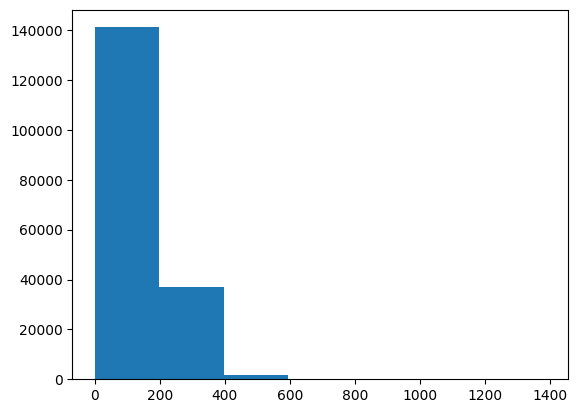

In [73]:
plt.hist(char_lens, bins=7);

In [74]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

So as we see, the average lenght of character we have per sentence is of 129 chars. The 95% of our sentences is going to be included on 290 characters or less.

Last time, the expected amount of words we got from the [PubMed200k RCT paper](https://arxiv.org/pdf/1710.06071) was 68k, and we saw that the 95% of lenght sentence was of 95 words.

For character embedding, we know that the max amount of characters will be 68, and the 95% of sentences will hold the information with 290 characters.

We will also add two extra tokens for spacing and for OOV ( unexpected or unrecognized characters).

In [75]:

# Get all keyboard characters for char-level embedding
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet,len(alphabet)

('abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~', 68)

In [76]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # num characters in alphabet + space + OOV token
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,  
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

Let's now adapt our vectorizer to the characters we have in our training dataset.

In [77]:
# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

2025-03-03 14:23:59.688877: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 504080352 exceeds 10% of free system memory.


As we did before with our first `text vectorizer`, let's check the most visualized characters and the least common as well.

In [78]:

# Check character vocabulary characteristics
char_vocab = char_vectorizer.get_vocabulary()
char_vocab = [str(word) for word in char_vocab]
print(f"Chars in vocabulary: {len(char_vocab)}")
print(f"Most common characters: {char_vocab[:5]}")
print(f"Least common characters: {char_vocab[-5:]}")

Chars in vocabulary: 28
Most common characters: ['', '[UNK]', 'e', 't', 'i']
Least common characters: ['k', 'x', 'z', 'q', 'j']


Let's see how our `text vectorizer` works with a random sentence.

In [79]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
I l l n e s s - r e l a t e d   a n x i e t y   w a s   c o m p a r a b l e   b e t w e e n   t r e a t m e n t   a r m s   a t   a l l   t i m e   p o i n t s   (   P   >   @   )   ,   r e g a r d l e s s   o f   c o p i n g   s t y l e   (   a c t i v e   o r   a v o i d a n t   )   .

Length of chars: 118

Vectorized chars:
[[ 4 12 12  6  2  9  9  8  2 12  5  3  2 10  5  6 24  4  2  3 19 20  5  9
  11  7 15 14  5  8  5 22 12  2 22  2  3 20  2  2  6  3  8  2  5  3 15  2
   6  3  5  8 15  9  5  3  5 12 12  3  4 15  2 14  7  4  6  3  9 14  8  2
  18  5  8 10 12  2  9  9  7 17 11  7 14  4  6 18  9  3 19 12  2  5 11  3
   4 21  2  7  8  5 21  7  4 10  5  6  3  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  

After running some random sentences, we see that our data is included length wise and the spaces are filled with padding correctly.

### Creating character embedding layer

Referencing again [Neural Netowrks for joint sentence classification in medical paper abstracts](https://arxiv.org/pdf/1710.06071), we can see that the output dimension for the embeding layer is 25, so we will create the same size.

In [80]:
from tensorflow.keras.layers import Embedding

# Create char embedding layer
Char_embedding_layer = Embedding(input_dim=NUM_CHAR_TOKENS, # number of different characters
                              output_dim=25, # embedding dimension of each character (same as Figure 1 in https://arxiv.org/pdf/1612.05251.pdf)
                              mask_zero=False, # don't use masks (this messes up model_5 if set to True)
                              name="char_embed")

# Test out character embedding layer
print(f"Charified text (before vectorization and embedding):\n{random_train_chars}\n")
char_embed_example = Char_embedding_layer(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
I l l n e s s - r e l a t e d   a n x i e t y   w a s   c o m p a r a b l e   b e t w e e n   t r e a t m e n t   a r m s   a t   a l l   t i m e   p o i n t s   (   P   >   @   )   ,   r e g a r d l e s s   o f   c o p i n g   s t y l e   (   a c t i v e   o r   a v o i d a n t   )   .



Embedded chars (after vectorization and embedding):
[[[ 0.00689639 -0.01488986 -0.02447064 ... -0.04922752  0.0143901
   -0.00110898]
  [-0.04837958  0.02375822 -0.03576883 ... -0.02070328 -0.02050257
    0.01578822]
  [-0.04837958  0.02375822 -0.03576883 ... -0.02070328 -0.02050257
    0.01578822]
  ...
  [ 0.01429936  0.04281589 -0.02518441 ...  0.04476773  0.02713389
   -0.00915016]
  [ 0.01429936  0.04281589 -0.02518441 ...  0.04476773  0.02713389
   -0.00915016]
  [ 0.01429936  0.04281589 -0.02518441 ...  0.04476773  0.02713389
   -0.00915016]]]

Character embedding shape: (1, 290, 25)


Now we are ready to build our next model with transfer-learning by feeding these values now.

### Building a new architecture with char embedding layer

We splitted our sentences into characters and gave them a specific numerical value with `char_vectorizer`and reprensented their relation as a feature vectore with `Char_embedding_layer`.

Our model will now take the character-based dataset, preprocess with these two elements and then continue with a structure similar to the one we used in **model_1**, using a Conv1D layer, Global Max Pooling 1D layer and a last classification layer with softmax activation function.

In [81]:
# Set random seed for weight initialization.
tf.random.set_seed(10)

# 1. Create the model.

from tensorflow.keras.layers import GlobalMaxPool1D,Input,Conv1D
from tensorflow.keras import Model


# Make Conv1D on chars only
inputs = Input(shape=(1,), dtype=tf.string)
char_vectors = char_vectorizer(inputs)
char_embeddings = Char_embedding_layer(char_vectors)
x = Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = GlobalMaxPool1D()(x)
outputs = Dense(num_classes, activation="softmax")(x)
model_4 = Model(inputs=inputs,
                         outputs=outputs,
                         name="model_3_conv1D_char_embedding")


In [82]:
model_4.summary()

Model: "model_3_conv1D_char_embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ char_vectorizer                 │ (None, 290)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ char_embed (Embedding)          │ (None, 290, 25)        │         1,750 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 290, 64)        │         8,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,139 (39.61 KB)

 Trainable params: 10,139 (39.61 KB)

 Non-trainable params: 0 (0.00 B)

In [83]:
# 2. Compile model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

We created before `prefetch datasets` for our word token-based dataset, so now we need to do the same for the modified character token-based dataset before training our model with it.

In [84]:
# Create train dataset
train_char_slices = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot))
train_char_dataset = train_char_slices.batch(32).prefetch(tf.data.AUTOTUNE)

# Create validation dataset
val_char_slices = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot))
val_char_dataset = val_char_slices.batch(32).prefetch(tf.data.AUTOTUNE)

# Create test dataset
test_char_slices = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot))
test_char_dataset = test_char_slices.batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [85]:

# 3. Fit the model
model_4_history = model_4.fit(train_char_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1 * len(val_char_dataset)))

Epoch 1/3


562/562 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - accuracy: 0.4275 - loss: 1.3893 - val_accuracy: 0.5947 - val_loss: 1.0330
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - accuracy: 0.5852 - loss: 1.0364 - val_accuracy: 0.6303 - val_loss: 0.9463
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - accuracy: 0.6295 - loss: 0.9389 - val_accuracy: 0.6699 - val_loss: 0.8726


### Evaluating model 4 : our character based embedding Conv1d model

In [86]:
# Evaluate on whole validation dataset (we only validated on 10% of batches during training)
model_4.evaluate(val_char_dataset)

# Make predictions (our model outputs prediction probabilities for each class)
model_4_pred_probs = model_4.predict(val_char_dataset)

# Convert pred probs to classes
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

# Calculate model_4 results
model_4_results = modelgraph.calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

  1/945 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step - accuracy: 0.3125 - loss: 1.4187

945/945 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - accuracy: 0.6535 - loss: 0.8887
945/945 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step


{'accuracy': 65.14629948364889,
 'precision': 0.6497494626595238,
 'recall': 0.6514629948364888,
 'f1': 0.6418306369144445}

## Model 5: Word + Char token embedding (hybrid)

We are building up slowly to the model used in [Neural Networks for Joint Sentence Classification in Medical Paper Abstracts](https://arxiv.org/pdf/1710.06071), so as they do in the paper, they have a hybrid combination of word+char tokenized embedding.

We have built them separately but now we will do them together. 

The input structure will be separated but similar on both ways, and they will be jointed after being embedded with [tf.keras.layers.concatenate](https://www.google.com/search?q=tensorflow+layers+concatenate&oq=tensorflow+layers+concat&gs_lcrp=EgZjaHJvbWUqBwgAEAAYgAQyBwgAEAAYgAQyBggBEEUYOTIICAIQABgWGB4yBggDEEUYQNIBCDU2MDhqMGo3qAIAsAIA&sourceid=chrome&ie=UTF-8).

In [87]:
# Model word-based token: Using Universal Sentence Encoder

# Set random seed for weight initialization.
keras.utils.set_random_seed(10)

# Create the model
token_inputs = keras.layers.Input(shape=[], dtype=tf.string,name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = keras.layers.Dense(128, activation="relu")(token_embeddings)

token_model = keras.Model(inputs=token_inputs, outputs=token_outputs, name="model_token")

We need to remake now char text vectorizer and char embedding layer as we need to be compatible with the keras model done with `tf_keras` to be able to support `tf_hub_embedding_layer`

In [88]:
from tf_keras import layers
import tf_keras as keras

# Create char embedding layer
Char_embedding_layer_keras = layers.Embedding(input_dim=NUM_CHAR_TOKENS, # number of different characters
                              output_dim=25, # embedding dimension of each character (same as Figure 1 in https://arxiv.org/pdf/1612.05251.pdf)
                              mask_zero=False, # don't use masks (this messes up model_5 if set to True)
                              name="char_embed")

In [89]:
# Create char-level token vectorizer instance
char_vectorizer_keras = layers.TextVectorization(max_tokens=NUM_CHAR_TOKENS,  
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer_keras")

Remember to train also our `char_vectorizer_keras` now:

In [90]:
# Adapt character vectorizer to training characters
char_vectorizer_keras.adapt(train_chars)

In [91]:
# Set random seed for weight initialization.
keras.utils.set_random_seed(10)

# Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_input")
char_vectors = char_vectorizer_keras(char_inputs)
char_embeddings = Char_embedding_layer_keras(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings)  # bi-LSTM shown in Figure 1 of https://arxiv.org/pdf/1612.05251.pdf
char_model = keras.Model(inputs=char_inputs, outputs=char_bi_lstm)

In [92]:
# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output, 
                                                                  char_model.output])
    

Now, mixing both models and continuing to build a more robust model, we will include a series of dropout and dense layers, finalizing with our output layer for performing the classification.

In [93]:
# 4. Create output layers - addition of dropout discussed in 4.2 of https://arxiv.org/pdf/1612.05251.pdf
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation="relu")(combined_dropout) # slightly different to Figure 1 due to different shapes of token/char embedding layers
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

In [94]:
# 5. Construct model with char and token inputs
model_5 = keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_5_token_and_char_embeddings")

This might be the largest model created so far here, let's take a look at the summary:

In [95]:
model_5.summary()

Model: "model_5_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 token_input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer_keras (Tex  (None, 290)                  0         ['char_input[0][0]']          
 tVectorization)                                                                                  
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978 

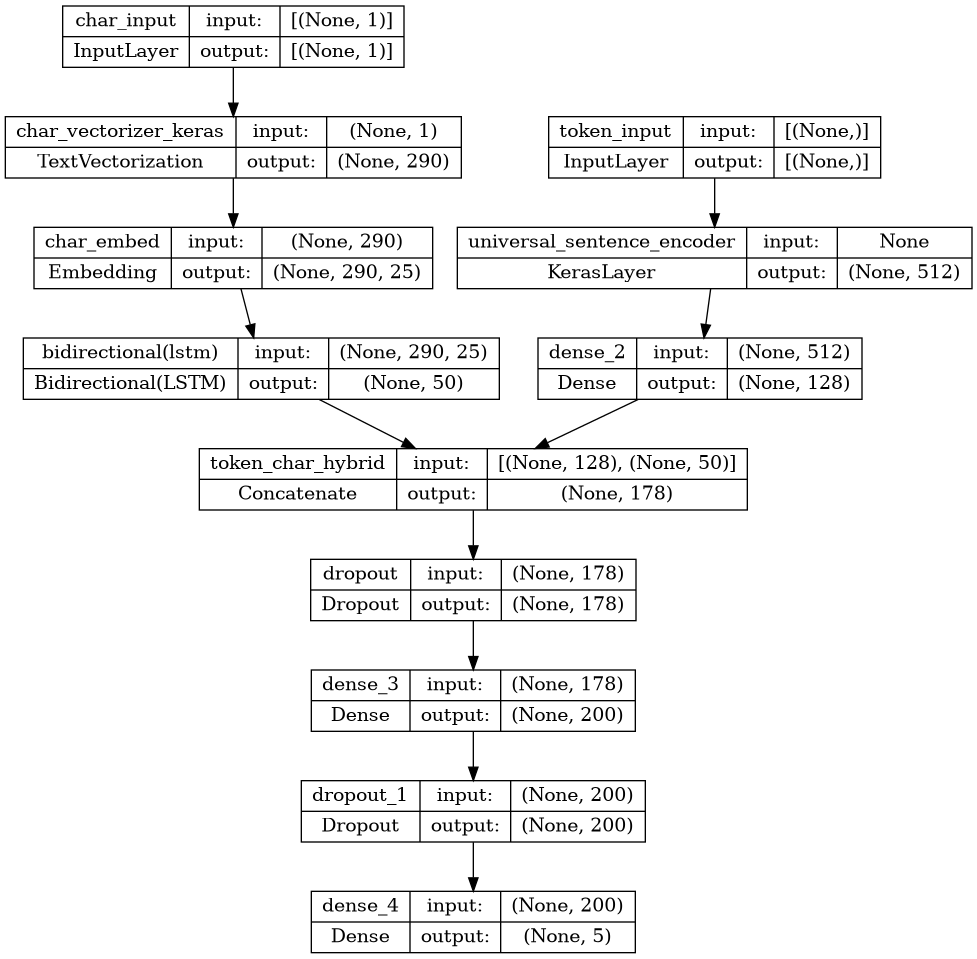

In [96]:
# Plot the token, char, positional embedding model
from tf_keras.utils import plot_model
plot_model(model_5, show_shapes=True, show_layer_names=True)

Section 4.2 from [Joint Sentence Classification in Medical Paper Abstracts](https://arxiv.org/pdf/1710.06071) mentions the use of SGD optimizer. But just to be consistent to our experiments and comparing results, we will keep using Adam.

In [97]:
# 2.Compile token char model
model_5.compile(loss="categorical_crossentropy",
                optimizer=keras.optimizers.Adam(), 
                metrics=["accuracy"])

In [98]:

# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 

# Repeat same steps validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [99]:
# Check out training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [100]:
# Fit the model on tokens and chars
model_5_history = model_5.fit(train_char_token_dataset, # train on dataset of token and characters
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))
     

Epoch 1/3


562/562 [==============================] - 70s 112ms/step - loss: 0.9647 - accuracy: 0.6169 - val_loss: 0.7865 - val_accuracy: 0.6985
Epoch 2/3
562/562 [==============================] - 66s 118ms/step - loss: 0.8022 - accuracy: 0.6940 - val_loss: 0.7167 - val_accuracy: 0.7264
Epoch 3/3
562/562 [==============================] - 71s 127ms/step - loss: 0.7698 - accuracy: 0.7048 - val_loss: 0.6929 - val_accuracy: 0.7330


### Evaluating model 5: our hybrid model

In [101]:

# Evaluate on the whole validation dataset
model_5.evaluate(val_char_token_dataset)

945/945 [==============================] - 67s 71ms/step - loss: 0.7008 - accuracy: 0.7319


[0.7008463740348816, 0.7319276928901672]

In [102]:
# Make predictions (our model outputs prediction probabilities for each class)
model_5_pred_probs = model_5.predict(val_char_token_dataset)

# Convert pred probs to classes
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

# Calculate model_5 results
model_5_results = modelgraph.calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

945/945 [==============================] - 62s 62ms/step


{'accuracy': 73.19277108433735,
 'precision': 0.733141205584774,
 'recall': 0.7319277108433735,
 'f1': 0.7299736632670323}

In [103]:
modelgraph.CompareModelScores(model_4_results, model_5_results)

Baseline accuracy: 65.15, New accuracy: 73.19, Difference: 8.05
Baseline precision: 0.65, New precision: 0.73, Difference: 0.08
Baseline recall: 0.65, New recall: 0.73, Difference: 0.08
Baseline f1: 0.64, New f1: 0.73, Difference: 0.09


## Model 6: Model 5 + position embedding

There is some information we still have from our dataset that we haven't used yet. We can try to help our model classifying each sentence type by adding an extra input of relevant information : `line number` and `total lines`.

In [104]:
train_df_20k.head(10)

,type,text,line_number,total_lines,abstract_id
0,OBJECTIVE,To investigate the efficacy of @ weeks of dail...,1,12,24293578
1,METHODS,A total of @ patients with primary knee OA wer...,2,12,24293578
2,METHODS,Outcome measures included pain reduction and i...,3,12,24293578
3,METHODS,Pain was assessed using the visual analog pain...,4,12,24293578
4,METHODS,Secondary outcome measures included the Wester...,5,12,24293578
5,METHODS,"Serum levels of interleukin @ ( IL-@ ) , IL-@ ...",6,12,24293578
6,RESULTS,There was a clinically relevant reduction in t...,7,12,24293578
7,RESULTS,The mean difference between treatment arms ( @...,8,12,24293578
8,RESULTS,"Further , there was a clinically relevant redu...",9,12,24293578
9,RESULTS,These differences remained significant at @ we...,10,12,24293578


As we see, we can try adding `positional embedding`to help our model that the first sentences are going to be related to `background`or `objective`, followed by `methods` and ending by `results` and `conclusions`.

In [105]:
class_names

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

### Positional embeddings

We have already the information in our dataframes related to line position and total line per abstract. Still, having i.e. a line in the 5th position does not mean is 5 times the first line.

When our integers carry other information rather than absolute value, we might need to do some type of encoding to ensure that the information they carry is passed through the network efficiently.

This is why we will turn our `line_number` values into [one hot encoding values](https://www.tensorflow.org/api_docs/python/tf/one_hot).

In [106]:
train_df_20k["line_number"].value_counts()
     

line_number
1     15000
2     15000
3     15000
4     15000
5     14992
6     14949
7     14758
8     14279
9     13346
10    11981
11    10041
12     7892
13     5853
14     4152
15     2835
16     1861
17     1188
18      751
19      462
20      286
21      162
22      101
23       66
24       33
25       22
26       14
27        7
28        4
29        3
30        1
31        1
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

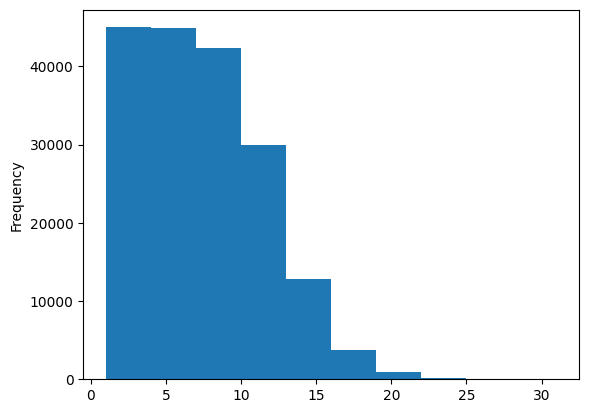

In [107]:

# Check the distribution of "line_number" column
train_df_20k.line_number.plot.hist()

In [108]:
line_number_95_percentile = np.percentile(train_df_20k.line_number, 95)
line_number_95_percentile

np.float64(14.0)

Let's create then encoding for 15 classes. Any line that would be in the 15th position or higher will be assigned to all 0s.

In [109]:

# Use TensorFlow to create one-hot-encoded tensors of our "line_number" column 
train_line_numbers_one_hot = tf.one_hot(train_df_20k["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df_20k["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df_20k["line_number"].to_numpy(), depth=15)
     

In [110]:
# Check one-hot encoded "line_number" feature samples
train_line_numbers_one_hot.shape, train_line_numbers_one_hot[:15]

(TensorShape([180040, 15]),
 <tf.Tensor: shape=(15, 15), dtype=float32, numpy=
 array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0.

Doing the same for total lines...

In [111]:
train_df_20k["total_lines"].value_counts()

total_lines
12    24468
11    23639
13    22113
10    19400
14    18438
15    14610
9     12285
16    10768
8      7464
17     7429
18     5202
7      3353
19     3344
20     2480
21     1281
6      1146
22      770
23      759
24      264
5       215
25      200
26      182
27       81
29       58
4        32
31       31
28       28
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

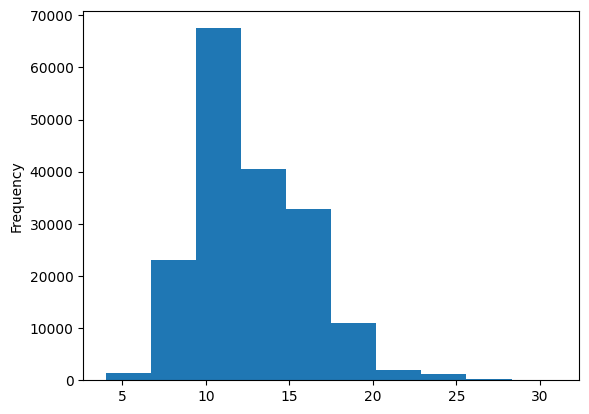

In [112]:

# Check the distribution of "total_lines" column
train_df_20k.total_lines.plot.hist()

In [113]:
total_lines_95_percentile = np.percentile(train_df_20k["total_lines"], 95)
total_lines_95_percentile

np.float64(19.0)

We can create for total lines 20 classes as seeing the histogram, it will cover better the great majority of the samples.

In [114]:
# Use TensorFlow to create one-hot-encoded tensors of our "total_lines" column 
train_total_lines_one_hot = tf.one_hot(train_df_20k["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df_20k["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df_20k["total_lines"].to_numpy(), depth=20)

# Check shape and samples of total lines one-hot tensor
train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]),
 <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0

### Creating a 3-way input for our model

We have our positional embedding ready.

Our next steps for creating our model are:

1. Creating a token model for token (words) inputs.
2. Creating a char model for char inptus.
3. Creating a line number model for the one-hot encoder line number inputs.
4. Creating a total lines model for the one-hot encoder total lines inputs.
5. Combining token and char models with concatenate into a token-char embedding model.
6. Combining line number and total lines and token-char embedding for a token-char positional model.
7. Creating output for classification for our model and combining all into one model.

In [138]:
# 1. Create token model for token (words) inputs
token_inputs = keras.layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = keras.layers.Dense(128, activation="relu")(token_embeddings)
token_model = keras.Model(inputs=token_inputs, outputs=token_outputs, name="model_token")

# 2. Create char model for char inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_input")
char_vectors = char_vectorizer_keras(char_inputs)
char_embeddings = Char_embedding_layer_keras(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = keras.Model(inputs=char_inputs, outputs=char_bi_lstm, name="model_char")

# 3. Create line number model for the one-hot encoded line number inputs
line_number_inputs = layers.Input(shape=(15,), dtype=tf.int32, name="line_number_input")
line_number_outputs = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = keras.Model(inputs=line_number_inputs, outputs=line_number_outputs, name="model_line_number")

# 4. Create total lines model for the one-hot encoded total lines inputs
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.int32, name="total_lines_input")
total_lines_outputs = layers.Dense(32, activation="relu")(total_lines_inputs)
total_lines_model = keras.Model(inputs=total_lines_inputs, outputs=total_lines_outputs, name="model_total_lines")

# 5. Combine token and char models with concatenate into a token-char embedding model
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output, char_model.output])
z = layers.Dense(256, activation="relu")(token_char_concat)
z = layers.Dropout(0.5)(z)

# 6. Combine line number and total lines and token-char embedding for a token-char positional model
combined_models = layers.Concatenate(name="token_char_positional_hybrid")([z, line_number_model.output, total_lines_model.output])

# 7. Create output for classification for our model and combining all into one model
output_layer = layers.Dense(num_classes, activation="softmax")(combined_models)

# Construct the final model
model_6 = keras.Model(inputs=[token_model.input, char_model.input, line_number_model.input, total_lines_model.input],
                      outputs=output_layer,
                      name="model_6_token_char_positional_embeddings")

With our model now built, let's take a look to its architecture

In [139]:
# Summary of the model
model_6.summary()

Model: "model_6_token_char_positional_embeddings"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 token_input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer_keras (Tex  (None, 290)                  0         ['char_input[0][0]']          
 tVectorization)                                                                                  
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2

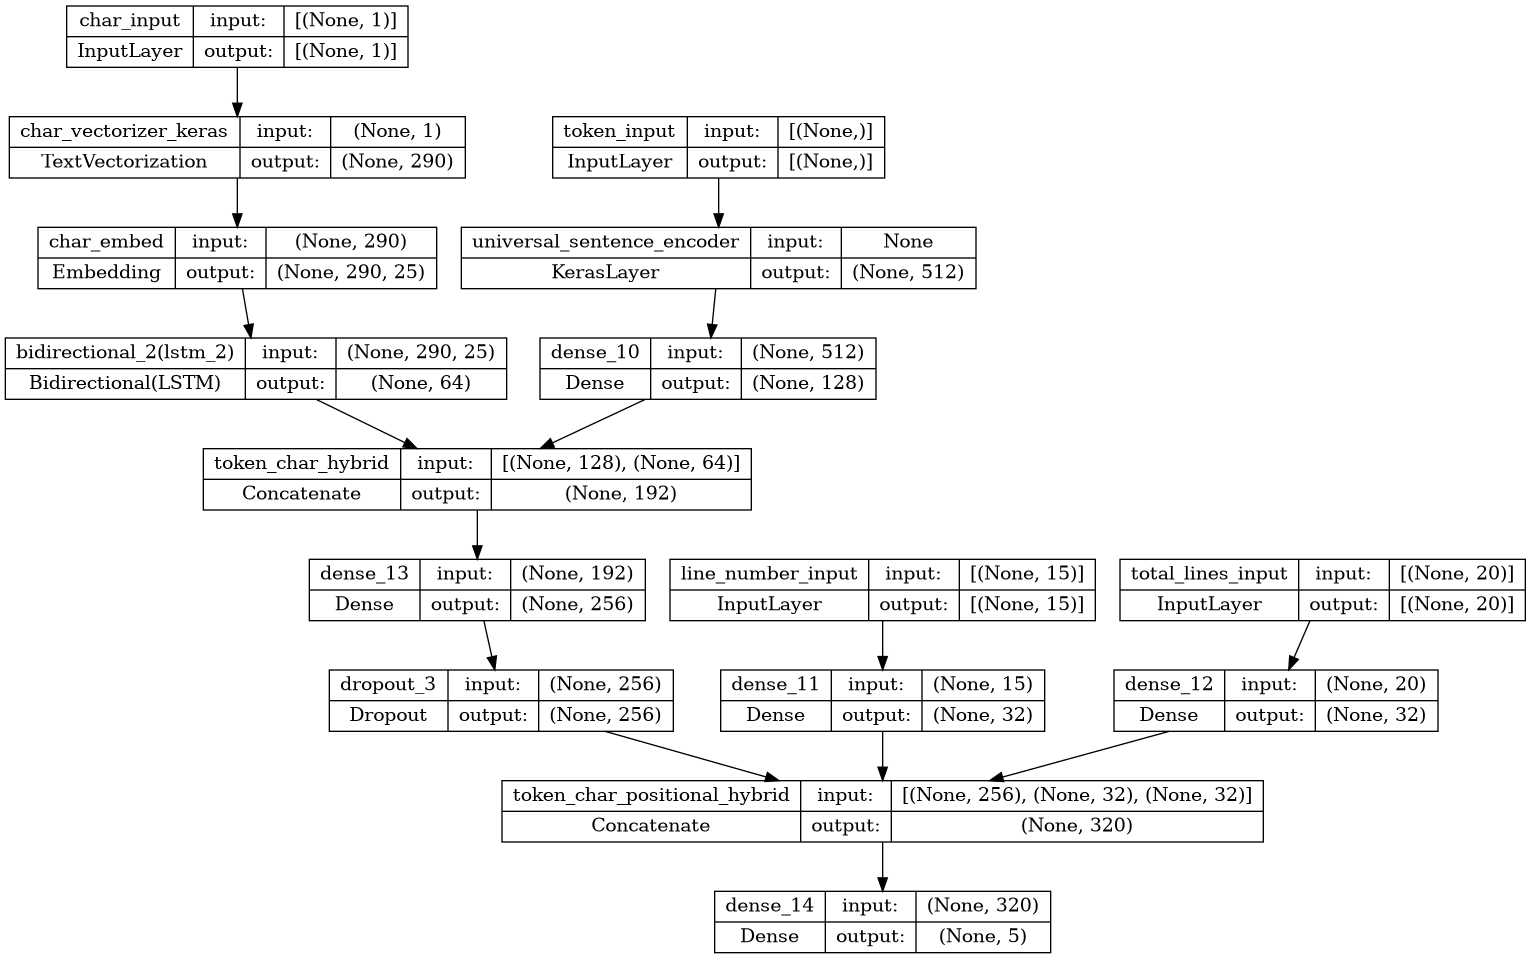

In [140]:
# Plot the token, char, positional embedding model
from tf_keras.utils import plot_model
plot_model(model_6, show_shapes=True, show_layer_names=True)

We have built now quite a large model, with nothing but 256,932,283 total parameters. Comparing to [Neural Networks for Joint Sentence Classification in Medical Paper Abstracts](https://arxiv.org/pdf/1710.06071), we still have some differences:

1. We are using Universal Sentence Encoder from TFHUb instead of GloVe embeddings.
2. We are using a dense layer on top of token-hybrid embedding instead of bi-LSTM layer.
3. In their NN, it is used an optimization layer (which helps to make sure sequence labels come out in a respectable order). To makeup for the lack of this layer in our model, we've created the positional embeddings layers.
4. We have frozen layers in our TFHub layers, compared to their trained char-embedding layers.
5. Their optimizer is SGD, compared to the ADAM we are using.

In [141]:

# Observe <tensorflow_hub.keras_layer.KerasLayer object at 0x7f77248489d0> False
for layer in model_6.layers:
  print(layer, layer.trainable)
     

<tf_keras.src.engine.input_layer.InputLayer object at 0x7fcde8204050> True
<tf_keras.src.engine.input_layer.InputLayer object at 0x7fcddb005dd0> True
<tf_keras.src.layers.preprocessing.text_vectorization.TextVectorization object at 0x7fcde81b3490> True
<tensorflow_hub.keras_layer.KerasLayer object at 0x7fce63695990> False
<tf_keras.src.layers.core.embedding.Embedding object at 0x7fcdd9610110> True
<tf_keras.src.layers.core.dense.Dense object at 0x7fcddbd4a7d0> True
<tf_keras.src.layers.rnn.bidirectional.Bidirectional object at 0x7fcddbb9bc50> True
<tf_keras.src.layers.merging.concatenate.Concatenate object at 0x7fcdd84e71d0> True
<tf_keras.src.layers.core.dense.Dense object at 0x7fcdd840efd0> True
<tf_keras.src.engine.input_layer.InputLayer object at 0x7fce60f52c50> True
<tf_keras.src.engine.input_layer.InputLayer object at 0x7fcde8573990> True
<tf_keras.src.layers.regularization.dropout.Dropout object at 0x7fcdd8401610> True
<tf_keras.src.layers.core.dense.Dense object at 0x7fcdd836f0

When compiling the model, we will use `label smoothing`. This will soften a bit our model's predictions, helping us to reduce overfitting.

In [142]:
# 2. Compile the model
model_6.compile(loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer=keras.optimizers.Adam(),
                metrics=["accuracy"])



### Prepare our datasets

As we have done before, we need to re-create our datasets as this model now has 4 different types of inputs. Our new model needs the following inputs :

1. Train line numbers one-hot tensor (train_line_numbers_one_hot)
2. Train total lines one-hot tensor (train_total_lines_one_hot)
3. Token-level sequences tensor (train_sentences)
4. Char-level sequences tensor (train_chars)

In [143]:

# Create training and validation datasets (all four kinds of inputs)
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices(( train_sentences, # train tokens 
                                                                 train_chars, # train chars
                                                                train_line_numbers_one_hot, # line number
                                                                train_total_lines_one_hot)) # total lines
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # train labels
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) # combine data and labels
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32, drop_remainder=True).prefetch(tf.data.AUTOTUNE)  # turn into batches, drop remainder, and prefetch

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices(( val_sentences,
                                                               val_chars,
                                                              val_line_numbers_one_hot,
                                                              val_total_lines_one_hot))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset_prediction = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

# Check input shapes
train_pos_char_token_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(32,), dtype=tf.string, name=None), TensorSpec(shape=(32,), dtype=tf.string, name=None), TensorSpec(shape=(32, 15), dtype=tf.float32, name=None), TensorSpec(shape=(32, 20), dtype=tf.float32, name=None)), TensorSpec(shape=(32, 5), dtype=tf.float64, name=None))>

In [164]:
# Test dataset
test_pos_char_token_data = tf.data.Dataset.from_tensor_slices((test_sentences,  # test tokens
                                                               test_chars,  # test chars
                                                               test_line_numbers_one_hot,  # line number
                                                               test_total_lines_one_hot))  # total lines
test_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)  # test labels
test_pos_char_token_dataset = tf.data.Dataset.zip((test_pos_char_token_data, test_pos_char_token_labels))  # combine data and labels
test_pos_char_token_dataset = test_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)  # turn into batches and prefetch


In [ ]:
def VerifyDatasetTensor(dataset, batch_size=32):
    """
    Verify the number of tensors in each tf.data.Dataset and the number of tensor slices in each batch.
    
    Args:
    dataset (tf.data.Dataset): The dataset to verify.
    batch_size (int): The batch size used in the dataset.
    
    Returns:
    None
    """
    previous_shapes = None
    
    # Iterate through all batches in the dataset
    for batch_num, batch in enumerate(dataset):
        data, labels = batch
        #print(f"Batch {batch_num + 1}:")
        # Print the number of tensors in the dataset
        #print(f"  Number of tensors in the dataset: {len(data)}")
        # Print the shape of each tensor in the batch
        current_shapes = [tensor.shape for tensor in data]

        # Check if the current batch shapes are different from the previous batch shapes
        if previous_shapes and current_shapes != previous_shapes:
            shape_diff = [(prev, curr) for prev, curr in zip(previous_shapes, current_shapes) if prev != curr]
            raise ValueError(f"Error: The shape of the current batch {batch_num + 1} is different from the previous batch. "
                             f"Shape differences: {shape_diff}")
        
        previous_shapes = current_shapes
        #print("-" * 50)

# Verify the training dataset
VerifyDatasetTensor(train_pos_char_token_dataset)

# Verify the validation dataset
VerifyDatasetTensor(val_pos_char_token_dataset)

### Training our model

In [145]:
# 3. Fit the model

# Fit the token, char and positional embedding model
history_model_6 = model_6.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              epochs=3,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1 * len(val_pos_char_token_dataset)))

Epoch 1/3


562/562 [==============================] - 55s 86ms/step - loss: 1.0970 - accuracy: 0.7232 - val_loss: 0.9846 - val_accuracy: 0.8068
Epoch 2/3
562/562 [==============================] - 62s 110ms/step - loss: 0.9671 - accuracy: 0.8158 - val_loss: 0.9500 - val_accuracy: 0.8338
Epoch 3/3
562/562 [==============================] - 54s 97ms/step - loss: 0.9491 - accuracy: 0.8257 - val_loss: 0.9398 - val_accuracy: 0.8301


### Evaluating Model 6

This model is the most complex so far and it is paying off as the accuracy and validation accuracy are the highest so far. Excellent! Helping our model knowing the line position to classify the type of line has been definitely useful.

In [146]:
# Make predictions (our model outputs prediction probabilities for each class)
model_6_pred_probs = model_6.predict(val_pos_char_token_dataset_prediction)

# Convert pred probs to classes
model_6_preds = tf.argmax(model_6_pred_probs, axis=1)
model_6_preds

# Calculate model_6 results
model_6_results = modelgraph.calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_6_preds)
model_6_results

945/945 [==============================] - 65s 67ms/step


{'accuracy': 83.0266119422746,
 'precision': 0.8291029757433925,
 'recall': 0.830266119422746,
 'f1': 0.8292265294592601}

## Comparing results

We have done very different models and we have added different layers of complexity trying to improve the accuracy of the models.

So far, we have only use the 20k dataset, but we will check what result we obtain running the 200k dataset and comparing to the model listed in [PubMed 200k RCT: a Dataset for Sequential Sentence Classification in Medical Abstracts paper.](https://arxiv.org/pdf/1710.06071).

As we have all our results saved in dictionaries, let's create a Pandas DF to compare and visualize.

In [155]:

# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "custom_token_embed_conv1d": model_1_results,
                                  "model_1_+_LSTM": model_2_results,
                                  "transfer_learning_token_embed": model_3_results,
                                  "char_embed_conv1d": model_4_results,
                                  "hybrid_char_token_embed": model_5_results,
                                  "hybrid_char_token_pos_embed": model_6_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,72.183238,0.718647,0.721832,0.698925
custom_token_embed_conv1d,78.432411,0.780886,0.784324,0.782128
model_1_+_LSTM,76.886668,0.767328,0.768867,0.765415
transfer_learning_token_embed,71.289554,0.713447,0.712896,0.709914
char_embed_conv1d,65.146299,0.649749,0.651463,0.641831
hybrid_char_token_embed,73.192771,0.733141,0.731928,0.729974
hybrid_char_token_pos_embed,83.026612,0.829103,0.830266,0.829227


In [156]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

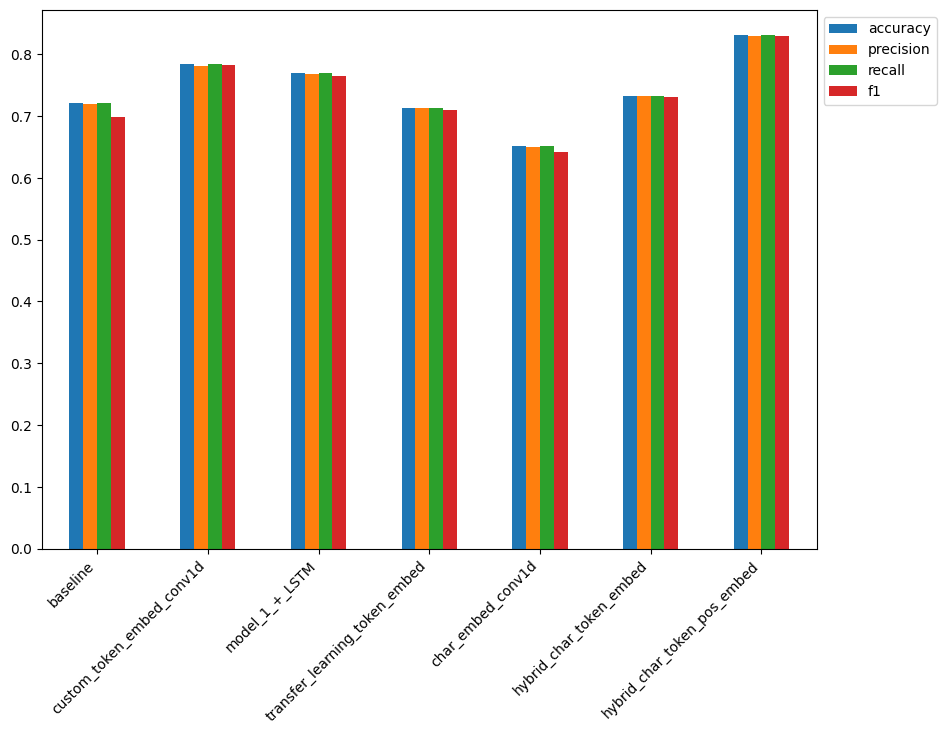

In [157]:

# Plot and compare all of the model results
ax = all_model_results.plot(kind="bar", figsize=(10, 7))
plt.xticks(rotation=45, ha='right')
ax.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

Let's now compare only F1 scores as done in PubMed paper.

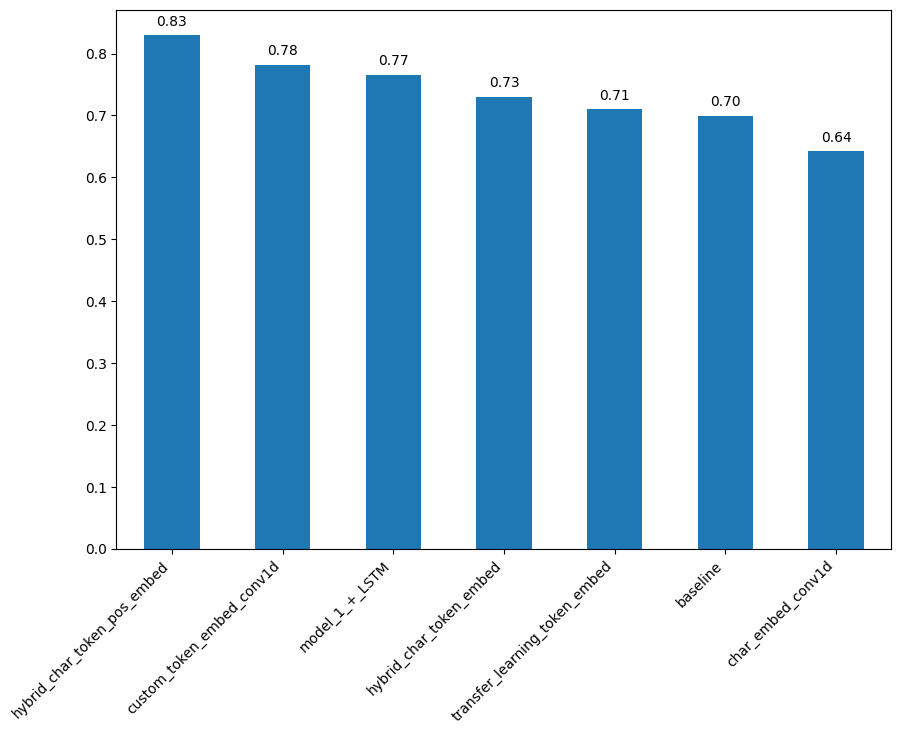

In [163]:
ax = all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7))
plt.xticks(rotation=45, ha='right')

# Annotate each bar with the specific value
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

Our model_6 seems to be the greatest so far comparing the F1 scores. From [PubMed 200k RCT: a Dataset for Sequential Sentence Classification in Medical Abstracts paper.](https://arxiv.org/pdf/1710.06071), we can still see on Table 3 that ANN-based model the score managed on 20K on Test Dataset is 90.0.

To make a more approachable comparison with our best model, let's also generate a prediction for test dataset. The result, if the data pool is homogeneous, should be practically the same.

### Evaluating results

First, we can start making predictions for the test dataset. As we were explaining before, it makes sense the values of the test predictions are mostly the same as the validation prediction.

In [166]:
# Make predictions (our model outputs prediction probabilities for each class)
model_6_pred_probs_test = model_6.predict(test_pos_char_token_dataset)

# Convert pred probs to classes
model_6_preds_test = tf.argmax(model_6_pred_probs_test, axis=1)
model_6_preds_test

# Calculate model_6 results
model_6_results_test = modelgraph.calculate_results(y_true=test_labels_encoded,
                                    y_pred=model_6_preds_test)
model_6_results_test

942/942 [==============================] - 98s 104ms/step


{'accuracy': 82.80736684917869,
 'precision': 0.8266369356975937,
 'recall': 0.828073668491787,
 'f1': 0.8269880992836942}

To understand better what our model excels at and what can be improved, let's examine the best and the worst predictions.

In [175]:
test_pred_classes = [class_names[i] for i in model_6_preds_test]
test_pred_classes[:10]

['OBJECTIVE',
 'BACKGROUND',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'RESULTS',
 'BACKGROUND']

Let's add some extra information to the test_df we have from before.

In [176]:
test_df_20k["prediction"] = test_pred_classes
test_df_20k["pred_prob"] = tf.reduce_max(model_6_pred_probs_test, axis=1).numpy()
test_df_20k["correct"] = test_df_20k["prediction"] == test_df_20k["type"]
test_df_20k.head(40)

,type,text,line_number,total_lines,abstract_id,prediction,pred_prob,correct
0,BACKGROUND,This study analyzed liver function abnormaliti...,1,9,24845963,OBJECTIVE,0.482934,False
1,RESULTS,A post hoc analysis was conducted with the use...,2,9,24845963,BACKGROUND,0.342279,False
2,RESULTS,Liver function tests ( LFTs ) were measured at...,3,9,24845963,METHODS,0.780943,False
3,RESULTS,Survival analyses were used to assess the asso...,4,9,24845963,METHODS,0.589600,False
4,RESULTS,The percentage of patients with abnormal LFTs ...,5,9,24845963,RESULTS,0.664806,True
5,RESULTS,When mean hemodynamic profiles were compared i...,6,9,24845963,RESULTS,0.858852,True
6,RESULTS,Multivariable analyses revealed that patients ...,7,9,24845963,RESULTS,0.588288,True
7,CONCLUSIONS,Abnormal LFTs are common in the ADHF populatio...,8,9,24845963,CONCLUSIONS,0.459676,True
8,CONCLUSIONS,Elevated MELD-XI scores are associated with po...,9,9,24845963,RESULTS,0.467774,False
9,BACKGROUND,Minimally invasive endovascular aneurysm repai...,1,13,24469619,BACKGROUND,0.585910,True


In [177]:
test_df_20k.head(40)

,type,text,line_number,total_lines,abstract_id,prediction,pred_prob,correct
0,BACKGROUND,This study analyzed liver function abnormaliti...,1,9,24845963,OBJECTIVE,0.482934,False
1,RESULTS,A post hoc analysis was conducted with the use...,2,9,24845963,BACKGROUND,0.342279,False
2,RESULTS,Liver function tests ( LFTs ) were measured at...,3,9,24845963,METHODS,0.780943,False
3,RESULTS,Survival analyses were used to assess the asso...,4,9,24845963,METHODS,0.589600,False
4,RESULTS,The percentage of patients with abnormal LFTs ...,5,9,24845963,RESULTS,0.664806,True
5,RESULTS,When mean hemodynamic profiles were compared i...,6,9,24845963,RESULTS,0.858852,True
6,RESULTS,Multivariable analyses revealed that patients ...,7,9,24845963,RESULTS,0.588288,True
7,CONCLUSIONS,Abnormal LFTs are common in the ADHF populatio...,8,9,24845963,CONCLUSIONS,0.459676,True
8,CONCLUSIONS,Elevated MELD-XI scores are associated with po...,9,9,24845963,RESULTS,0.467774,False
9,BACKGROUND,Minimally invasive endovascular aneurysm repai...,1,13,24469619,BACKGROUND,0.585910,True


Let's try to sort now where the False predictions with the highest probability to ensure another type failed.

In [178]:
top_100_wrong = test_df_20k[test_df_20k["correct"] == False].sort_values("pred_prob", ascending=False)[:100]
top_100_wrong

,type,text,line_number,total_lines,abstract_id,prediction,pred_prob,correct
2388,RESULTS,The primary endpoint is the cumulative three-y...,5,14,24454728,METHODS,0.940842,False
1827,CONCLUSIONS,NCT@ ( ClinicalTrials.gov ) .,19,19,25036218,BACKGROUND,0.933730,False
8545,METHODS,Pretest-posttest .,2,12,25204768,BACKGROUND,0.931518,False
13874,CONCLUSIONS,Symptom outcomes will be assessed and estimate...,5,7,24886555,METHODS,0.927231,False
10452,BACKGROUND,To validate the association between accommodat...,1,11,24612686,OBJECTIVE,0.926828,False
...,...,...,...,...,...,...,...,...
13860,BACKGROUND,To evaluate efficacy and side effects of glyci...,1,10,24761877,OBJECTIVE,0.839278,False
4860,RESULTS,We randomly assigned @ patients with drug-resi...,3,11,24469436,METHODS,0.838891,False
12458,RESULTS,Home Monitoring patients were assessed remotel...,4,14,24595864,METHODS,0.838185,False
29116,CONCLUSIONS,"Compared with group M , both of group M+R and ...",8,8,25656375,RESULTS,0.838161,False


In [179]:
top_100_wrong.value_counts("type")

type
RESULTS        43
CONCLUSIONS    24
BACKGROUND     13
METHODS        13
OBJECTIVE       7
Name: count, dtype: int64

In [180]:
top_100_wrong.value_counts("prediction")

prediction
METHODS        45
BACKGROUND     17
RESULTS        16
CONCLUSIONS    12
OBJECTIVE      10
Name: count, dtype: int64

Going through the dataframe, we can see that many actual `conclussions`are mispredicted as `background`, but what about other relations? Counting from the top 100 mislabeled types, we see the amount of `methods` is highly wrong, while results is the opposite :  we should have more `results` but we only have 16% of them.

In [181]:
class_names

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

We could create a confusion matrix to explore better where are the most mislabeled types. We see our model effectively struggles a bit targeting `objective` as a `background`, and almost the same the other way around.

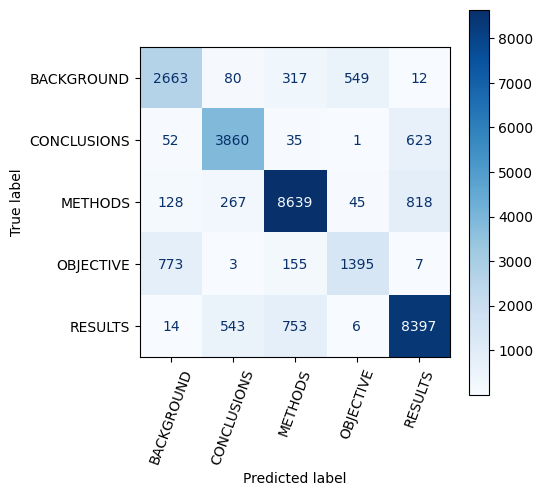

In [182]:
modelgraph.PlotConfusionMatrix(test_labels_encoded,model_6_preds_test
                               ,class_names)

We could still investigate and have a better look to some examples of the wrong predictions : 

In [196]:

# Investigate top wrong preds
for row in top_100_wrong[0:10].itertuples(index=False): # adjust indexes to view different samples
  type, text, line_number, total_lines, prediction, pred_prob, correct, _ = row
  print(f"Target: {type}, Pred: {prediction}, Prob: {pred_prob}, Line number: {line_number}, Total lines: {total_lines}\n")
  print(f"Text:\n{text}\n")
  print("-----\n")

Target: RESULTS, Pred: 24454728, Prob: METHODS, Line number: 5, Total lines: 14

Text:
The primary endpoint is the cumulative three-year HIV incidence .

-----

Target: CONCLUSIONS, Pred: 25036218, Prob: BACKGROUND, Line number: 19, Total lines: 19

Text:
NCT@ ( ClinicalTrials.gov ) .

-----

Target: METHODS, Pred: 25204768, Prob: BACKGROUND, Line number: 2, Total lines: 12

Text:
Pretest-posttest .

-----

Target: CONCLUSIONS, Pred: 24886555, Prob: METHODS, Line number: 5, Total lines: 7

Text:
Symptom outcomes will be assessed and estimates of cost-effectiveness made .

-----

Target: BACKGROUND, Pred: 24612686, Prob: OBJECTIVE, Line number: 1, Total lines: 11

Text:
To validate the association between accommodation and visual asthenopia by measuring objective accommodative amplitude with the Optical Quality Analysis System ( OQAS , Visiometrics , Terrassa , Spain ) , and to investigate associations among accommodation , ocular surface instability , and visual asthenopia while viewin

While there's room for improvement ( we can update with a part 2 in the futrue), we can try to test our model with real examples.

## Making example predictions

To make some real predictions, we will find some RCT abstract from PubMed, use some preprocessing functions to split the sentences and find how our model would predict the classification of each line.

As an example, let's take ['RCT of a manualized social treatment for high-functioning autism spectrum disorders](https://pubmed.ncbi.nlm.nih.gov/20232240/)

> This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.

Our model_6 needs 4 types of inputs :
* Text split sentences
* Text split in characters
* Number of each line
* Total number of lines


In [ ]:


# Save the model and verify it loads correctly.
model_6.save('NLP_abstract_simplify_model_6')
NLP_model_6 = keras.models.load_model('NLP_abstract_simplify_model_6')
NLP_model_6.summary()

In [224]:
abstract_example = "This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group."

We can use spacy to break down the abstract first into sentences, as is a library widely use for NLP for this purpose.

In [225]:
import spacy
# Create sentencizer - Source: https://spacy.io/usage/linguistic-features#sbd 
from spacy.lang.en import English
nlp = English() # setup English sentence parser

sentencizer = nlp.add_pipe("sentencizer") # create sentence splitting pipeline object
abstract_lines = [str(sent) for sent in nlp(abstract_example).sents]
abstract_lines, len(abstract_lines)

(['This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
  'Participants were randomly assigned to treatment or wait-list conditions.',
  'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
  'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
  'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
  'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
  'High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.',
  'Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.'],
 8)

In [257]:
# total lines
abstract_total_lines = []
for i in range(len(abstract_lines)):
    abstract_total_lines.append((len(abstract_lines) - 1))
# line number
abstract_line_numbers = [i for i in range(len(abstract_lines))]
# one-hot encoding line numbers
abstract_line_numbers_one_hot = tf.one_hot(abstract_line_numbers, depth=15)
# one-hot encoding total lines
abstract_total_lines_one_hot = tf.one_hot(abstract_total_lines, depth=20)
# Combine abstract lines into characters
abstract_chars = [SplitIntoChars(line) for line in abstract_lines]

In [259]:
abstract_total_lines_one_hot

<tf.Tensor: shape=(8, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=float32)>

In [248]:
abstract_line_numbers_one_hot

<tf.Tensor: shape=(7, 15), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)>

Seems looking okay, lets predict

In [258]:
# Convert abstract_lines and abstract_chars to tensors
abstract_lines_tensor = tf.constant(abstract_lines)
abstract_chars_tensor = tf.constant(abstract_chars)


# Predict
test_abstract_pred_probs = model_6.predict(x=(      tf.constant(abstract_lines),
                                                    tf.constant(abstract_chars),
                                                    abstract_line_numbers_one_hot,
                                                   abstract_total_lines_one_hot))

1/1 [==============================] - 0s 115ms/step


In [260]:
test_abstract_pred_probs

array([[0.0700263 , 0.73003745, 0.02216077, 0.12583   , 0.05194542],
       [0.1598625 , 0.05053713, 0.34475675, 0.29179528, 0.15304835],
       [0.20933087, 0.05188439, 0.35757896, 0.3023441 , 0.07886166],
       [0.18014884, 0.11949441, 0.46730042, 0.13951144, 0.0935449 ],
       [0.08421658, 0.108601  , 0.4262333 , 0.07225748, 0.30869165],
       [0.04342275, 0.09716829, 0.58116335, 0.05004621, 0.22819936],
       [0.03700289, 0.15429151, 0.08829209, 0.03027372, 0.69013983],
       [0.02320013, 0.09882852, 0.27020222, 0.03568347, 0.5720856 ]],
      dtype=float32)

In [261]:

# Turn prediction probabilities into prediction classes
test_abstract_preds = tf.argmax(test_abstract_pred_probs, axis=1)
test_abstract_preds
     

<tf.Tensor: shape=(8,), dtype=int64, numpy=array([1, 2, 2, 2, 2, 2, 4, 4])>

In [262]:
# Turn prediction class integers into string class names
test_abstract_pred_classes = [label_encoder.classes_[i] for i in test_abstract_preds]

# Visualize abstract lines and predicted sequence labels
for i, line in enumerate(abstract_lines):
  print(f"{test_abstract_pred_classes[i]}: {line}")
     

CONCLUSIONS: This RCT examined the efficacy of a manualized social intervention for children with HFASDs.
METHODS: Participants were randomly assigned to treatment or wait-list conditions.
METHODS: Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.
METHODS: A response-cost program was applied to reduce problem behaviors and foster skills acquisition.
METHODS: Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).
METHODS: Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.
RESULTS: High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.
RESULTS: Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.


This would be the input data :

> This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.

This would be the output

> BACKGROUND: This RCT examined the efficacy of a manualized social intervention for children with HFASDs.  
> OBJECTIVE: Participants were randomly assigned to treatment or wait-list conditions.  
> METHODS: Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.  
> METHODS: A response-cost program was applied to reduce problem behaviors and foster skills acquisition.  
> RESULTS: Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).  
> RESULTS: Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.  
> RESULTS: High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.  
> RESULTS: Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.  
